## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [4]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'),
 PosixPath('data/lyft/train'),
 PosixPath('data/lyft/models'),
 PosixPath('data/lyft/tmp')]

In [5]:
def isolate_roads(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == 7] = 255
    img_np_R[img_np_R == 6] = 255

    img_np_R[img_np_R != 255] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/train_masks')
    image.save(dest/filename.name)

In [6]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

# def show_img(im, figsize=(10,10), ax=None, seg=False, channel=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     new_img = np.copy(im) # Prevent the original image from being modified
#     if seg:
#         new_img = new_img[:,:,0] # Grab just the red channel from the RGB image
#         if channel:
#             new_img[new_img != channel] = 0 # Display only the requested classes (roads etc)
#     ax.imshow(new_img.astype(np.int32))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     return ax

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. Run this code only once.

In [7]:
seg_PATH = Path('train/CameraSeg')
original_segs = list(seg_PATH.iterdir())

# for image in original_segs:
#     isolate_roads(image)

In [8]:
PATH = Path('data/lyft')
input_images = PATH/'train'
output_images = PATH/'train_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/0.png')]

In [9]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/train_masks/5.png'),
 PosixPath('data/lyft/train_masks/88.png'),
 PosixPath('data/lyft/train_masks/0.png')]

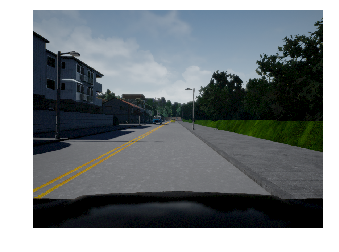

In [10]:
real_world = open_image(list(input_images.iterdir())[0])
show_img(real_world)

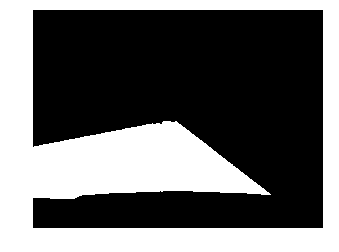

In [11]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Resize images

In [12]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'
sz = 128
bs = 64

In [19]:
ims = [open_image(list(input_images.iterdir())[i]) for i in range(16)]
masks = [open_image(list(output_images.iterdir())[i]) for i in range(16)]

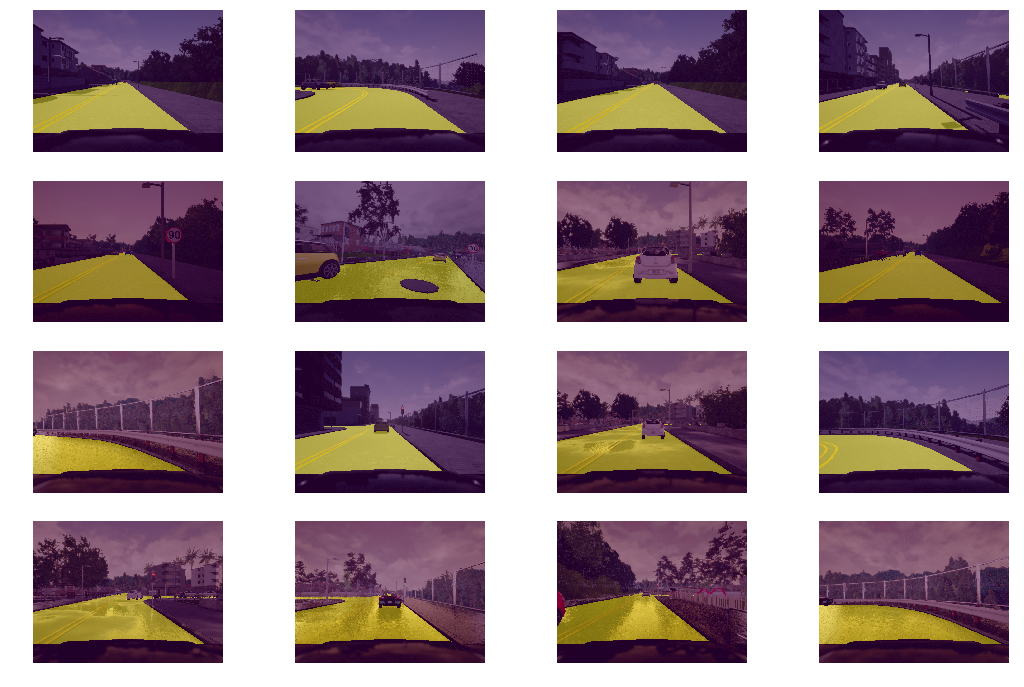

In [21]:
fig, axes = plt.subplots(4,4, figsize=(18,12))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)

In [33]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [34]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [35]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [36]:
len(val_x),len(trn_x),trn_x[0], trn_y[0]

(200,
 800,
 PosixPath('data/lyft/train/284.png'),
 PosixPath('data/lyft/train_masks/284.png'))

In [37]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [38]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [39]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [41]:
# This cell is for educational purposes, to see inside the resnet arch

# class Empty(nn.Module): 
#     def forward(self,x): return x

# models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = ConvLearner(md, models)
# learn.summary()

In [42]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [43]:
flatten_channel = Lambda(lambda x: x[:,0])

In [44]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [45]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                  
    0      0.937672   4663488.14 0.676835  



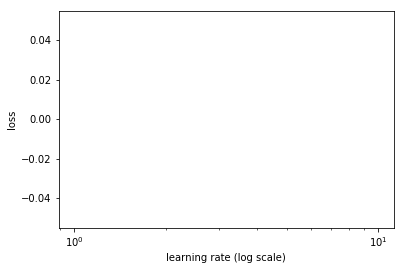

In [46]:
learn.lr_find()
learn.sched.plot()

In [47]:
lr=4e-2

In [48]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.408201   5.865311   0.718015  
    1      0.262315   0.628763   0.847796                  
    2      0.205554   0.18177    0.935845                  
    3      0.171936   0.102326   0.954868                  
    4      0.150397   0.099443   0.956104                  



[array([0.09944]), 0.9561041259765625]

In [49]:
learn.save('tmp')

In [50]:
learn.load('tmp')

In [51]:
py,ay = learn.predict_with_targs()

In [52]:
ay.shape

(200, 128, 128)

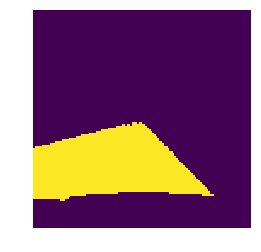

In [53]:
show_img(ay[0]);

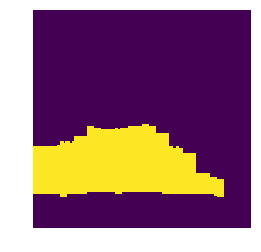

In [55]:
show_img(py[0]>0);

In [56]:
learn.unfreeze()

In [57]:
learn.bn_freeze(True)

In [58]:
lrs = np.array([lr/100, lr/10, lr])/4

In [59]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.254907   0.191856   0.88382   
    1      0.212533   0.115072   0.945167                  
    2      0.174283   0.088631   0.958781                  
    3      0.146342   0.077949   0.964762                  
    4      0.125408   0.066975   0.969691                  
    5      0.109732   0.060426   0.974614                  
    6      0.097957   0.056833   0.974457                   
    7      0.088547   0.050363   0.979523                   
    8      0.080531   0.047891   0.980436                   
    9      0.074187   0.046164   0.983143                   
    10     0.06888    0.046285   0.982645                   
    11     0.064168   0.042577   0.984745                   
    12     0.06004    0.040925   0.984868                   
    13     0.056244   0.039138   0.984716                   
    14     0.052884   0.037246   0.985059                   
    15     0.04988    0.036554   0.986195      

[array([0.03234]), 0.9877459716796875]

In [60]:
py,ay = learn.predict_with_targs()

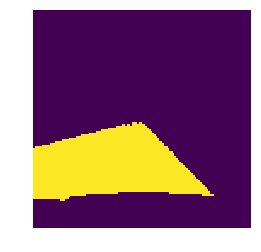

In [61]:
show_img(ay[0]);

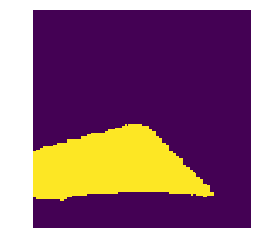

In [62]:
show_img(py[0]>0);

# thresh=np.percentile(py[0], 83) # experimentally determined threshold -- be careful!
# pred = np.copy(py[0])
# pred.shape
# pred[pred<thresh] = 0
# pred[pred>=thresh] = 255
# show_img(pred)